In [1]:
import scqubits
import numpy as np
from scipy.optimize import minimize
from CoupledQuantumSystems.systems import *
import matplotlib.pyplot as plt
import pickle
from scipy.optimize import curve_fit
import scipy
from scipy.special import erfc
from skimage.transform import radon
from CoupledQuantumSystems.qobj_manip import find_dominant_frequency,get_product_vectorized,dressed_to_product_vectorized
from CoupledQuantumSystems.systems import FluxoniumOscillatorSystem
import numpy as np
from CoupledQuantumSystems.mcsolve_utils import *
from CoupledQuantumSystems.drive import DriveTerm, square_pulse_with_rise_fall
from CoupledQuantumSystems.mcsolve_utils import pack_mcsolve_chunks, pack_pkl_files_to_zip, merge_results
import matplotlib.pyplot as plt
import qutip
import pickle


In [6]:
qubit_level = 40
EJ = 3
EC = EJ/6
EL = EJ/25
qbt = scqubits.Fluxonium(EJ=EJ,EC=EC,EL=EL,flux=0,cutoff=110,truncated_dim=qubit_level)
evals = qbt.eigenvals(qubit_level)
6.8 - (evals[7]-evals[0])

-0.03385425262611452

In [3]:

Er =  6.8

g = 0.2

max_ol = 100
max_ql = 30
system = FluxoniumOscillatorSystem(
    EJ = EJ,
    EC = EC,
    EL = EL,
    Er = Er,
    g_strength = g,
    qubit_level = max_ql,
    osc_level = max_ol,
    # kappa = 0.004,
    products_to_keep=[[ql, ol] for ql in range(max_ql) for ol in range(max_ol) ],
    computaional_states = '1,2'
    )


energies=  system.hilbertspace.eigenvals(max_ql * max_ol)
def dressed_ener(ql,ol):
    return energies[system.product_to_dressed[(ql,ol)]]
# def print_stats():
#     # print(f"\nqubit 12 transition and differential stark at different oscillator level")
#     # print(f"qbt freq at osc {0}:\t{(dressed_ener(2,0)-dressed_ener(1,0))}")
#     # ground_freq = dressed_ener(2,0)-dressed_ener(1,0)
#     # for i in range(1,max_ol-1):
#     #     freq = dressed_ener(2,i)-dressed_ener(1,i)
#     #     print(f"qbt freq at osc {i}:\t{freq:.5f}, \tdiff to at osc ground {freq - ground_freq:.5f}, {abs(freq - ground_freq)/ground_freq*100:.4f}% diff")

#     print(f"\noscillator freq at qubit level:\t0 \t 1 \t 2 \t 3:")
#     print(f"oscillator transition 0-1: \t{dressed_ener(0,1)-dressed_ener(0,0):.5f}\t{dressed_ener(1,1)-dressed_ener(1,0):.5f}\t{dressed_ener(2,1)-dressed_ener(2,0):.5f}\t{dressed_ener(3,1)-dressed_ener(3,0):.5f}")
#     for i in range(1,max_ol-1):
#         print(f"oscillator transition {i}-{i+1}: \t{dressed_ener(0,i+1)-dressed_ener(0,i):.5f}\t{dressed_ener(1,i+1)-dressed_ener(1,i):.5f}\t{dressed_ener(2,i+1)-dressed_ener(2,i):.5f}\t{dressed_ener(3,i+1)-dressed_ener(3,i):.5f}  oscillator frequency coupled to qubit 0th state compared to 00-01 (non-linearity): {(dressed_ener(0,i+1)-dressed_ener(0,i))  -(dressed_ener(0,1)-dressed_ener(0,0))}")

#     print(f"")
#     print(f"10-11: {(dressed_ener(1,1)-dressed_ener(1,0)):.4f}, diff to 00-01: {abs((dressed_ener(0,1)-dressed_ener(0,0))    -(dressed_ener(1,1)-dressed_ener(1,0)))}")
#     print(f"20-21: {(dressed_ener(2,1)-dressed_ener(2,0)):.4f}, diff to 00-01: {abs((dressed_ener(0,1)-dressed_ener(0,0))    -(dressed_ener(2,1)-dressed_ener(2,0)))}")
# print_stats()
# # plot_specturum(system.qbt, system.osc, system.hilbertspace,num_levels = 50)

In [4]:
(dressed_ener(1,1)-dressed_ener(1,0)) - (dressed_ener(2,1)-dressed_ener(2,0))

-1.5741482825681885e-05

In [7]:
dressed_ener(0,1)-dressed_ener(0,0)

6.7990355408288075

In [10]:
(dressed_ener(1,1)-dressed_ener(1,0))

6.800636940935658

In [9]:
6.8 - 6.7990355408288075

0.0009644591711923667

In [11]:
6.800636940935658 - 6.7990355408288075

0.0016014001068507255

In [15]:
id_wrapped_resonator_destory = qutip.tensor(qutip.identity(max_ql), qutip.destroy(max_ol))
id_wrapped_fluxonium_destory = qutip.tensor(qutip.destroy(max_ql), qutip.identity(max_ol))
resonator_creation_arr = id_wrapped_resonator_destory.dag().full()
resonator_destory_arr= id_wrapped_resonator_destory.full()
fluxonium_creation_arr = id_wrapped_fluxonium_destory.dag().full()
fluxonium_destory_arr= id_wrapped_fluxonium_destory.full()

ladder_overlap = system.get_ladder_overlap_arr(resonator_creation_arr)


In [16]:


def find_next_in_branch(dressed_idx_of_qubit_i_resonator_n:int):
    return np.argmax(ladder_overlap[:,dressed_idx_of_qubit_i_resonator_n])

diagonalization_idx_arr = np.zeros((max_ql,max_ol),dtype=int)
diagonalization_idx_arr_with_marks = np.zeros((max_ql,max_ol),dtype=int)
overlap_idx_arr = np.zeros((max_ql,max_ol),dtype=int)
for ql in range(max_ql):
    for ol in range(max_ol):
        diagonalization_idx_arr[ql,ol] = system.product_to_dressed[(ql,ol)]
        diagonalization_idx_arr_with_marks[ql,ol] = system.product_to_dressed[(ql,ol)]

        if ol < 1:
            overlap_idx_arr[ql,ol] = system.product_to_dressed[(ql,ol)]
        else:
            overlap_idx_arr[ql,ol] = np.argmax(ladder_overlap[:,overlap_idx_arr[ql,ol-1]])

np.allclose(diagonalization_idx_arr, overlap_idx_arr)

False

In [17]:

for ql in range(max_ql):
    for ol in range(max_ol):
        system.product_to_dressed[(ql,ol)] =  overlap_idx_arr[ql,ol] 

system.set_sign_multiplier()

 /tmp/ipykernel_10980/1703544453.py: 18ComplexWarning: Casting complex values to real discards the imaginary part
 /tmp/ipykernel_10980/1703544453.py: 20

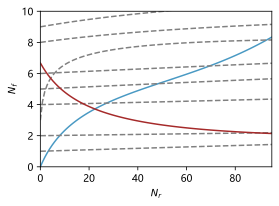

In [18]:
fig,ax = plt.subplots(1,1,figsize=(4,3))
qls = list(range(10))

for ql in qls:
    linestyle = '-'
    if ql == 0:
        color = '#4999c3'
    elif ql == 7:
        color = 'brown'
    else:
        color = 'grey'
        linestyle = '--'
    dressed_idx_arr = overlap_idx_arr[ql]
    photon_num_arr = np.zeros((max_ol))
    fluxonium_num_arr = np.zeros((max_ol))
    for ol in range(max_ol):
        state_after_a = resonator_destory_arr @ system.evecs[dressed_idx_arr[ol]].full()
        photon_num_arr[ol] = np.sum(state_after_a**2)
        state_after_fluxnonium_a = fluxonium_destory_arr @ system.evecs[dressed_idx_arr[ol]].full()
        fluxonium_num_arr[ol] = np.sum(state_after_fluxnonium_a**2)

    ax.plot(photon_num_arr,fluxonium_num_arr,label=f'{ql}',color=color,linestyle=linestyle)

ax.set_ylim(0,10)
ax.set_xlim(0,max_ol-5)
ax.set_xlabel(r'$N_r$')
ax.set_ylabel(r'$N_f$')

plt.tight_layout()
# fig.savefig('hybridization.pdf')

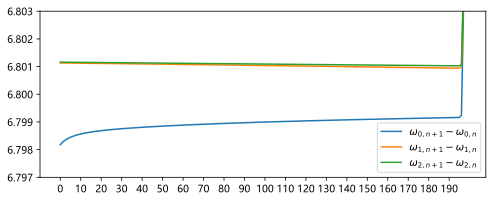

In [13]:
plt.figure(figsize = (8,3))
n_osc_lvls = max_ol-1
dressed_osc_frequencies = [[] for _ in range(3)]
for j in [0,1,2]:
    for i in range(0,max_ol-1):
        dressed_osc_frequencies[j].append(dressed_ener(j,i+1)-dressed_ener(j,i))
        
for j in [0,1,2]:
    plt.plot(list(range(max_ol-1))[:n_osc_lvls], dressed_osc_frequencies[j][:n_osc_lvls],label=rf'$\omega_{{{j},n+1}} - \omega_{{{j},n}}$')

plt.xticks(list(range(n_osc_lvls))[::10])
plt.ylim(Er-0.003, Er+0.003)
# plt.ylim(7.9,7.92)

# plt.xticklabels([str(i) for i in range(n_osc_lvls)])
plt.legend(loc='lower right')